### Miscellaneous Notebook:
Includes data exploration and modeling that were not ultimately important for the final project

In [1]:
#Same imports as Notebook plus some more
import pandas as pd 
import numpy as np 
np.random.seed(42)
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from nltk import FreqDist
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import PIL

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

###### Visualizing trends in the 'keyword' column:

In [3]:
train_df["keyword"].value_counts()

fatalities               45
deluge                   42
armageddon               42
damage                   41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

Visualizing the top 10 keywords in both train_df and test_df to see if we notice any trends:

In [4]:
top_train_keywords = train_df['keyword'].value_counts()[:10].sort_values(ascending=False).reset_index()
top_train_keywords

index  keyword
0   fatalities       45
1   armageddon       42
2       deluge       42
3      sinking       41
4  body%20bags       41
5         harm       41
6       damage       41
7     evacuate       40
8     outbreak       40
9      twister       40

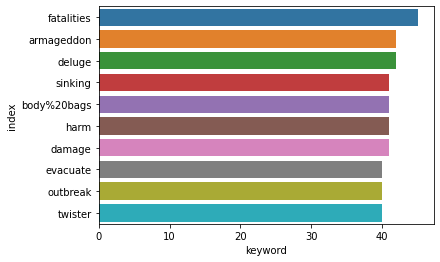

In [5]:
sns.barplot(y=top_train_keywords['index'], x=top_train_keywords['keyword']);

In [6]:
top_test_keywords = test_df['keyword'].value_counts()[:10].sort_values(ascending=False).reset_index()
top_test_keywords

index  keyword
0             deluged       23
1          demolished       22
2              rubble       22
3           snowstorm       21
4              sirens       21
5  first%20responders       21
6        obliteration       21
7        annihilation       21
8             seismic       21
9        bioterrorism       20

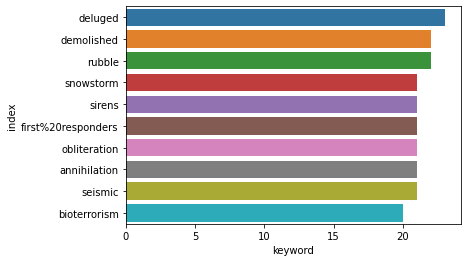

In [7]:
sns.barplot(y=top_test_keywords['index'], x=top_test_keywords['keyword']);

Visualizing the top 10 keywords for the train_df for each target value:

In [8]:
disaster_tweets = train_df[train_df['target']==1]

other_tweets = train_df[train_df['target']==0]

In [9]:
top_dis_keywords = disaster_tweets['keyword'].value_counts()[:10].sort_values(ascending=False).reset_index()
top_dis_keywords

index  keyword
0         derailment       39
1           outbreak       39
2           wreckage       39
3             debris       37
4            typhoon       37
5        oil%20spill       37
6  suicide%20bombing       32
7     suicide%20bomb       32
8           rescuers       32
9          evacuated       32

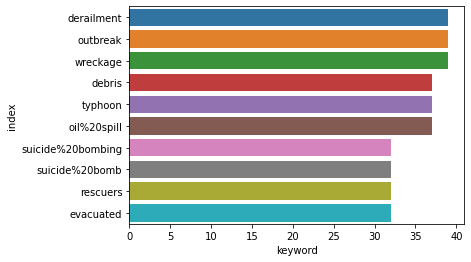

In [10]:
sns.barplot(y=top_dis_keywords['index'], x=top_dis_keywords['keyword']);

In [11]:
top_other_keywords = other_tweets['keyword'].value_counts()[:10].sort_values(ascending=False).reset_index()
top_other_keywords

index  keyword
0  body%20bags       40
1   armageddon       37
2         harm       37
3       deluge       36
4         ruin       36
5      wrecked       36
6      twister       35
7        siren       35
8         fear       35
9      explode       35

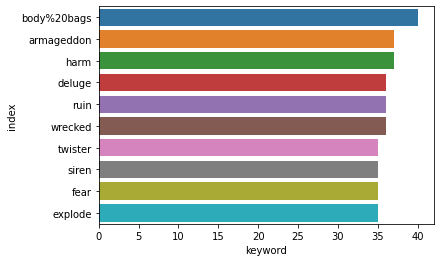

In [12]:
sns.barplot(y=top_other_keywords['index'], x=top_other_keywords['keyword']);

###### Calculating whether either disaster or non-disaster tweets contain a significantly different proportion of numbers:

In [13]:
num_query = r'\$(?:\d)?'

train_df["contains_number"] = train_df["text"].str.contains(num_query)
train_df["contains_number"].value_counts()


False    7575
True       38
Name: contains_number, dtype: int64

In [14]:
test_df["contains_number"] = test_df["text"].str.contains(num_query)
test_df["contains_number"].value_counts()

False    3241
True       22
Name: contains_number, dtype: int64

In [15]:
print("percent of disaster tweets containing numbers:", ((38/7575)*100))
print("percent of non-disaster tweets containing numbers:", ((22/3241)*100))

percent of disaster tweets containing numbers: 0.5016501650165017
percent of non-disaster tweets containing numbers: 0.6788028386300524


There is a slight difference, but overall this is probably not very important.

##### Trying out a model on the 'keyword' column instead of text:


In [16]:
train_keywords = train_df.dropna()
test_keywords = test_df.dropna()
train_keywords.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5080 entries, 31 to 7581
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5080 non-null   int64 
 1   keyword          5080 non-null   object
 2   location         5080 non-null   object
 3   text             5080 non-null   object
 4   target           5080 non-null   int64 
 5   contains_number  5080 non-null   bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 243.1+ KB


In [17]:
X_key = train_keywords.keyword
y_key = train_keywords.target

#y_key = train_df.target
X_train_key, X_test_key, y_train_key, y_test_key = train_test_split(X_key, y_key, test_size=0.25, random_state = 42)

In [18]:
stopwords_list = stopwords.words('english')

keyword_model = Pipeline([('vect', TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords_list)),
                          #('tfidf', TfidfTransformer()),
                           ('clf', MultinomialNB())
              ])
keyword_model.fit(X_train_key, y_train_key)
#CountVectorizer(tokenizer=word_tokenize, stop_words=stopwords_list))

y_pred_key = keyword_model.predict(X_test_key)

print('F1 %s' % f1_score(y_pred_key, y_test_key))
print(classification_report(y_test_key, y_pred_key))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.6634429400386848
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       736
           1       0.69      0.64      0.66       534

    accuracy                           0.73      1270
   macro avg       0.72      0.71      0.72      1270
weighted avg       0.72      0.73      0.72      1270



This model did not perform very well.

#### Manual word tokenization

In [19]:
stopwords_list = stopwords.words('english')

no_bad_chars = re.compile('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n - ]')
no_nums = re.compile('[\d-]')

def clean_text(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    text = ' '.join(word for word in text.split() if word not in stopwords_list)
    return text
    

train_df_cleaned = train_df['text'].apply(clean_text) 

test_df_cleaned = test_df['text'].apply(clean_text)

train_df_cleaned.head(10) 




0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked 'shelter place' notified offic...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
5    rockyfire update california hwy closed directi...
6    flood disaster heavy rain causes flash floodin...
7                          i'm top hill see fire woods
8    there's emergency evacuation happening buildin...
9                       i'm afraid tornado coming area
Name: text, dtype: object

In [20]:
# Tokenizing the data:
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

train_df_tokenized = train_df_cleaned.copy()
test_df_tokenized = test_df_cleaned.copy()
train_df_tokenized = train_df_cleaned.apply(tokenizer.tokenize)
test_df_tokenized = test_df_cleaned.apply(tokenizer.tokenize)


In [21]:
train_df_tokenized

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ahrary, control, wild, fires, california, eve...
7610                           [utc, km, volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [22]:
X = train_df.text
y = train_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [23]:
X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned = X_test.apply(clean_text)

In [24]:
X_train_tokenized = X_train_cleaned.apply(tokenizer.tokenize)
X_test_tokenized = X_test_cleaned.apply(tokenizer.tokenize)

X_train_tokenized.explode()
X_test_tokenized.explode()

2644             new
2644          weapon
2644           cause
2644    unimaginable
2644     destruction
            ...     
1032            blue
7195         nuclear
7195            bomb
7195        terrible
7195          weapon
Name: text, Length: 16654, dtype: object

In [25]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    


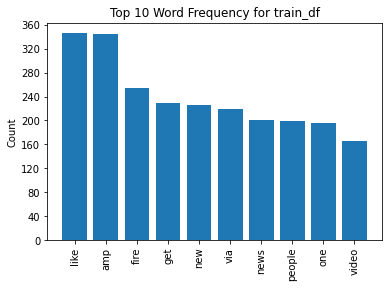

In [26]:
train_freq_dist = FreqDist(train_df_tokenized.explode())
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for train_df")

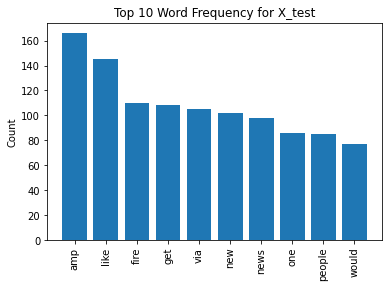

In [27]:
test_freq_dist = FreqDist(test_df_tokenized.explode())
visualize_top_10(test_freq_dist, "Top 10 Word Frequency for X_test")

Many of the most common words are the same in both the training df and the test df.

In [28]:
#Creating this visualization for disaster and non-disaster tweets of train_df
disaster_tweets_cleaned = disaster_tweets['text'].apply(clean_text)
other_tweets_cleaned = other_tweets['text'].apply(clean_text)

In [29]:
disaster_tweets_tokenized = disaster_tweets_cleaned.apply(tokenizer.tokenize)
other_tweets_tokenized = other_tweets_cleaned.apply(tokenizer.tokenize)


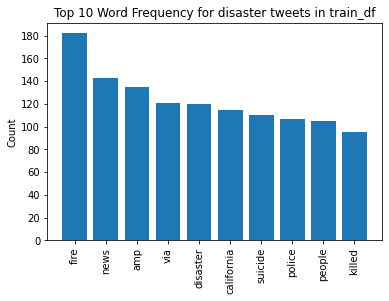

In [30]:
dis_tweets_freq_dist = FreqDist(disaster_tweets_tokenized.explode())
visualize_top_10(dis_tweets_freq_dist, "Top 10 Word Frequency for disaster tweets in train_df")

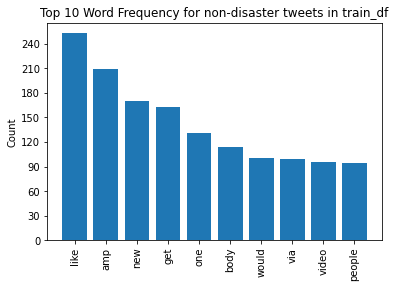

In [31]:
other_tweets_freq_dist = FreqDist(other_tweets_tokenized.explode())
visualize_top_10(other_tweets_freq_dist, "Top 10 Word Frequency for non-disaster tweets in train_df")

The most common words for disaster tweets and non-disaster tweets look pretty different.

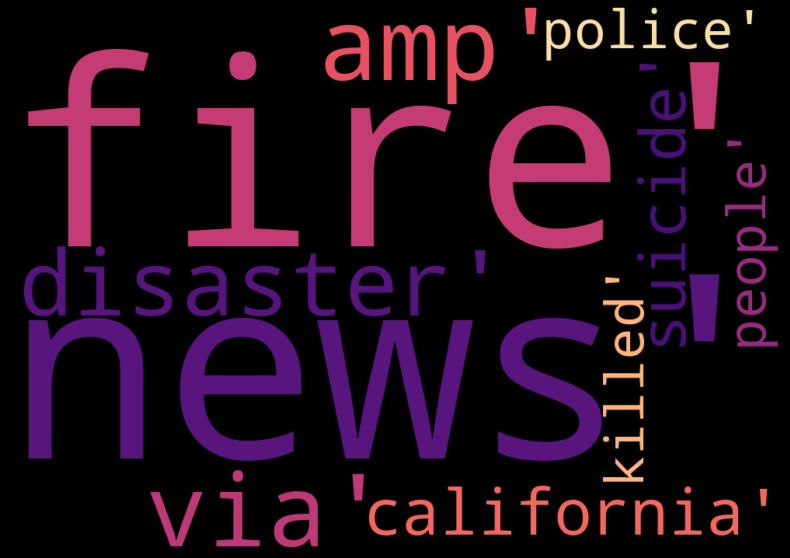

In [71]:
from matplotlib import colormaps

top_10_dis = list(zip(*dis_tweets_freq_dist.most_common(10)))

top_10_dis = ' '.join(str(e) for e in top_10_dis)


wordcloud = WordCloud(width=1000, height=700,
                      stopwords = STOPWORDS,
                      colormap= 'magma',
                      collocations=True).generate(top_10_dis)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

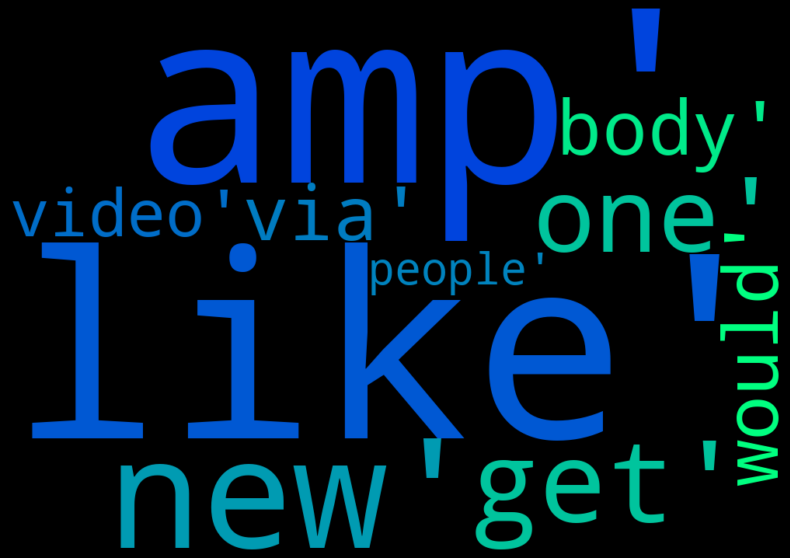

In [76]:
top_10_non = list(zip(*other_tweets_freq_dist.most_common(10)))

top_10_non = ' '.join(str(e) for e in top_10_non)


wordcloud = WordCloud(width=1000, height=700,
                      stopwords = STOPWORDS,
                      colormap= 'winter',
                      collocations=True).generate(top_10_non)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [72]:
dis_tweets_freq_dist

FreqDist({'fire': 182, 'news': 143, 'amp': 135, 'via': 121, 'disaster': 120, 'california': 115, 'suicide': 110, 'police': 107, 'people': 105, 'killed': 95, ...})

In [35]:
top_10_dis = list(zip(*dis_tweets_freq_dist.most_common(10)))


top_10_dis = ' '.join(str(e) for e in top_10_dis)
top_10_dis

"('fire', 'news', 'amp', 'via', 'disaster', 'california', 'suicide', 'police', 'people', 'killed') (182, 143, 135, 121, 120, 115, 110, 107, 105, 95)"

It looks like in both disaster tweets and non-disaster tweets, the words 'amp', 'people', and 'via' are both very common. I wonder how this impacts our model...

In [36]:
amp = train_df.text.str.contains('amp$|amp-|amp ', flags = re.IGNORECASE, regex = True)
via = train_df.text.str.contains('via$|via-|via ', flags = re.IGNORECASE, regex = True)
people = train_df.text.str.contains('people$|people-|people ', flags = re.IGNORECASE, regex = True)


In [37]:
train_df[amp][:10]

id                keyword                      location  \
74     107               accident                North Carolina   
671    968                  blaze                           NaN   
1260  1816  buildings%20on%20fire                    World Wide   
1771  2544              collision                Sacramento, CA   
2220  3177                 deluge  Enniscrone & Aughris, Sligo    
2952  4243                drowned                         India   
3203  4597       emergency%20plan                    Dallas, TX   
3665  5219               fatality                   Hueco Mundo   
3690  5251               fatality          Christiana,Tennessee   
3913  5564                  flood                      New York   

                                                   text  target  \
74    I-77 Mile Marker 31 South Mooresville  Iredell...       1   
671   @UABStephenLong @courtlizcamp Total tweet fail...       0   
1260  1943: Poland - work party prisoners in the Naz...       1   
1771  Traffic Collision - No Injury: I5 S at I5 S 43...       1   
2220  Back on the beach after the deluge.  Surf camp...       1   
2952  Hundreds of migrants feared drowned off Libya:...       1   
3203  @chrisroth98 @chaselabsports in an emergency s...       1   
3665  I liked a @YouTube video from @vgbootcamp http...       0   
3690  I liked a @YouTube video from @vgbootcamp http...       0   
3913  Spot Flood Combo 53inch 300W Curved Cree LED W...       1   

      contains_number  
74              False  
671             False  
1260            False  
1771            False  
2220            False  
2952            False  
3203            False  
3665            False  
3690            False  
3913            False

It looks like 'amp' is usually referring to the '&' symbol and should probably be dropped.

In [38]:
train_df.text[via].iloc[10]

'U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/MatIJwkzbh via @Change'

It also looks like 'via' is not a useful word to have in our data.

In [39]:
train_df.text[people].iloc[1:5]

10           Three people died from the heat wave so far
108    @afterShock_DeLo im speaking from someone that...
133    People who say it cannot be done should not in...
168    airplane crashes on house in Colombia 12 peopl...
Name: text, dtype: object

People looks like it may still include useful information, so we'll keep it in our data.

#### Manual Word Vectorization

In [40]:
count_vec = CountVectorizer(max_features=10)
X_train_count_vectorized = count_vec.fit_transform(X_train_cleaned)
X_test_count_vectorized= count_vec.transform(X_test_cleaned)
#X_test_count_vectorized = count_vec.transform(X_test_tokenized)

pd.DataFrame.sparse.from_spmatrix(X_train_count_vectorized, columns=count_vec.get_feature_names())

amp  fire  get  like  new  news  one  people  via  video
0       0     0    0     0    0     0    0       0    0      0
1       0     0    0     0    0     0    0       0    0      0
2       0     0    0     1    1     0    1       0    0      0
3       0     0    0     0    0     0    0       0    0      0
4       0     0    0     0    0     0    0       0    0      0
...   ...   ...  ...   ...  ...   ...  ...     ...  ...    ...
5704    0     0    0     1    0     0    0       0    0      0
5705    0     0    0     0    0     0    0       0    0      0
5706    0     0    0     0    0     0    0       0    0      0
5707    0     0    0     0    0     0    0       0    0      0
5708    0     0    0     0    0     0    0       0    0      0

[5709 rows x 10 columns]

In [41]:
tfidf = TfidfVectorizer(max_features=10, tokenizer=word_tokenize)


X_train_vectorized1 = tfidf.fit_transform(X_train_cleaned)
X_test_vectorized1 = tfidf.transform(X_test_cleaned)
#Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized1, columns=tfidf.get_feature_names())

'   'm   's  amp  fire  get    i      like       new  news
0     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.000000  0.000000   0.0
1     1.0  0.0  0.0  0.0   0.0  0.0  0.0  0.000000  0.000000   0.0
2     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.670471  0.741936   0.0
3     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.000000  0.000000   0.0
4     0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.000000  0.000000   0.0
...   ...  ...  ...  ...   ...  ...  ...       ...       ...   ...
5704  0.0  0.0  0.0  0.0   0.0  0.0  0.0  1.000000  0.000000   0.0
5705  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.000000  0.000000   0.0
5706  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.000000  0.000000   0.0
5707  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.000000  0.000000   0.0
5708  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.000000  0.000000   0.0

[5709 rows x 10 columns]

#### Trying out various models:

In [42]:
mnb = MultinomialNB()
mnb.fit(X_train_count_vectorized, y_train)

MultinomialNB()

In [43]:
y_pred = mnb.predict(X_test_count_vectorized)

print('F1 %s' % f1_score(y_pred, y_test, average="macro"))
print(classification_report(y_test, y_pred))

F1 0.4830279015478744
              precision    recall  f1-score   support

           0       0.60      0.95      0.73      1091
           1       0.68      0.14      0.23       813

    accuracy                           0.60      1904
   macro avg       0.64      0.55      0.48      1904
weighted avg       0.63      0.60      0.52      1904



Performing tokenization, vectorization, and model fitting manually performs much worse than using a pipeline.

In [44]:
# Model with bigrams:
bigrams_model = Pipeline([('vect', CountVectorizer(max_features=None,
                                                    tokenizer=word_tokenize,
                                                   stop_words=stopwords_list,
                                                   ngram_range=(1,2))),
                           ('clf', MultinomialNB())
              ])
bigrams_model.fit(X_train_cleaned, y_train)


y_pred_bigr = bigrams_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred_bigr, y_test, average="macro"))
print(classification_report(y_test, y_pred_bigr))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7952741308160336
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.79      0.73      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904



In [46]:
# model with TF-IDF Vectorizer instead of CountVectorizer

model2 = Pipeline([('vect', TfidfVectorizer(tokenizer=word_tokenize,
                                           stop_words=stopwords_list)),
                   ('clf', MultinomialNB()),
                  ])
model2.fit(X_train_cleaned, y_train)


from sklearn.metrics import classification_report
y_pred2 = model2.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred2, y_test, average="macro"))
print(classification_report(y_test, y_pred2))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7917740240719726
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1091
           1       0.84      0.67      0.74       813

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.81      0.80      0.80      1904



In [47]:
#when stemming/lemmatizing, we are going to do the same to the stopwords, 
#so we don't want to remove them before this.

#Creating a function that cleans the text data without removing stopwords:

def clean_text_nostop(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text)
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") 
    text = text.lower() 
    return text
    
train_df_cleaned_nostop = train_df.copy()

train_df_cleaned_nostop['text'] = train_df_cleaned_nostop['text'].apply(clean_text_nostop)

X_nostop = train_df_cleaned_nostop.text
y_nostop = train_df_cleaned_nostop.target
X_train_nostop, X_test_nostop, y_train_nostop, y_test_nostop = train_test_split(X_nostop, y_nostop, test_size=0.25, random_state = 42)


In [50]:
# Lemmatizing the text to see if it improves our model
lemmatizer = WordNetLemmatizer() 
tokenizer=word_tokenize
def lem_and_tokenize(document):
    tokens = tokenizer(document)
    return [lemmatizer.lemmatize(token) for token in tokens]


lemm_stopwords = [lemmatizer.lemmatize(word) for word in stopwords_list]

In [51]:
# Lemmatized data model
lemm_model = Pipeline([('vect', CountVectorizer(
                         stop_words=lemm_stopwords,
                         tokenizer=lem_and_tokenize)),
                       ('clf', MultinomialNB()),
              ])
lemm_model.fit(X_train_nostop, y_train_nostop)


from sklearn.metrics import classification_report
y_lemm_pred= lemm_model.predict(X_test_nostop)

print('F1 %s' % f1_score(y_lemm_pred, y_test_nostop))
print(classification_report(y_test_nostop, y_lemm_pred))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7583120204603581
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.79      0.73      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904



In [52]:
#Try RF?
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_count_vectorized, y_train)
y_hat = rf.predict(X_test_count_vectorized)
f1_score(y_test, y_hat)

0.23170731707317072

The RF model performed very poorly.

In [53]:
train_df_cleaned

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked 'shelter place' notified offic...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ahrary control wild fires california even nort...
7610                                utc km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [54]:
#Attempting POS Tagging

from nltk import pos_tag
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [55]:
stopwords_list = stopwords.words('english')

no_bad_chars = re.compile('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n - ]')
no_nums = re.compile('[\d-]')

def clean_text_pos(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    #text = text.lower() 
    text = pos_tag(text)
    text = [(word[0], get_wordnet_pos(word[1])) for word in text]
    #text = ' '.join(word for word in text.split() if word not in stopwords_list)
    return text
    

train_df_pos = train_df.copy()

train_df_pos['pos'] = train_df_pos['text'].apply(clean_text_pos)

X_pos = train_df_pos.pos
y_pos = train_df_pos.target
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, test_size=0.25, random_state = 42)


In [56]:
train_df_pos

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  \
0     Our Deeds are the Reason of this #earthquake M...       1   
1                Forest fire near La Ronge Sask. Canada       1   
2     All residents asked to 'shelter in place' are ...       1   
3     13,000 people receive #wildfires evacuation or...       1   
4     Just got sent this photo from Ruby #Alaska as ...       1   
...                                                 ...     ...   
7608  Two giant cranes holding a bridge collapse int...       1   
7609  @aria_ahrary @TheTawniest The out of control w...       1   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1   
7611  Police investigating after an e-bike collided ...       1   
7612  The Latest: More Homes Razed by Northern Calif...       1   

      contains_number                                                pos  
0               False  [(O, n), (u, a), (r, n), ( , n), (D, n), (e, n...  
1               False  [(F, n), (o, n), (r, v), (e, n), (s, a), (t, n...  
2               False  [(A, n), (l, n), (l, n), ( , n), (r, n), (e, n...  
3               False  [( , a), ( , n), (p, n), (e, n), (o, n), (p, n...  
4               False  [(J, n), (u, a), (s, n), (t, n), ( , n), (g, n...  
...               ...                                                ...  
7608            False  [(T, n), (w, n), (o, n), ( , n), (g, n), (i, v...  
7609            False  [( , v), (a, n), (h, n), (r, n), (a, n), (r, n...  
7610            False  [(M, n), ( , n), ( , n), ( , n), ( , n), ( , n...  
7611            False  [(P, n), (o, n), (l, v), (i, a), (c, n), (e, v...  
7612            False  [(T, n), (h, n), (e, n), ( , n), (L, n), (a, n...  

[7613 rows x 7 columns]

In [57]:
vec = CountVectorizer
X_train_pos = X_train_pos.apply(vec)
y_train_pos = y_train_pos.apply(vec)

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass input=[(' ', 'a'), (' ', 'n'), ('T', 'n'), ('h', 'n'), ('i', 'n'), ('s', 'v'), (' ', 'n'), ('m', 'v'), ('a', 'n'), ('k', 'n'), ('e', 'n'), ('s', 'n'), (' ', 'n'), ('s', 'n'), ('e', 'n'), ('n', 'a'), ('s', 'n'), ('e', 'n'), (' ', 'n'), (' ', 'n'), ('P', 'n'), ('a', 'n'), ('p', 'n'), ('e', 'n'), ('r', 'n'), (' ', 'n'), ('b', 'n'), ('e', 'v'), ('a', 'n'), ('t', 'n'), ('s', 'n'), (' ', 'n'), ('r', 'n'), ('o', 'n'), ('c', 'n'), ('k', 'n'), (' ', 'n'), ('p', 'v'), ('a', 'n'), ('p', 'n'), ('e', 'n'), ('r', 'n'), (' ', 'n'), ('c', 'v'), ('o', 'a'), ('m', 'n'), ('e', 'n'), ('s', 'n'), (' ', 'n'), ('f', 'n'), ('r', 'n'), ('o', 'n'), ('m', 'n'), (' ', 'n'), ('w', 'n'), ('o', 'n'), ('o', 'n'), ('d', 'n'), (' ', 'n'), ('s', 'n'), ('o', 'n'), (' ', 'n'), ('w', 'n'), ('o', 'n'), ('o', 'n'), ('d', 'n'), (' ', 'n'), ('s', 'n'), ('h', 'n'), ('o', 'a'), ('u', 'a'), ('l', 'n'),

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [58]:
mod2 = MultinomialNB(alpha= 2.0,fit_prior = True)
mod2.fit(X_train_pos, y_train_pos)


y_pred_tuned2= mod2.predict(X_test_pos)


TypeError: float() argument must be a string or a number, not 'CountVectorizer'

In [ ]:
tuned_model2 = Pipeline([('vect', CountVectorizer(
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize,
    ngram_range = (1,3))),
                        ('clf', MultinomialNB(alpha= 2.0,fit_prior = True)),
              ])
tuned_model2.fit(X_train_pos, y_train_pos)


y_pred_tuned2= tuned_model2.predict(X_test_pos)

print('F1 %s' % f1_score(y_pred_tuned2, y_test_pos, average="macro"))
print(classification_report(y_test_pos, y_pred_tuned2))